In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2025-05-14 19:36:05--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-05-14 19:36:06--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  41.1MB/s    in 5.9s    

2025-05-14 19:36:12 (40.3 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [2]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import timm
import pandas as pd

# Step 2: Fix val/ structure based on val_annotations.txt
val_dir = '/kaggle/working/tiny-imagenet-200/val'
val_images_dir = os.path.join(val_dir, 'images')
annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# Parse val_annotations.txt
val_df = pd.read_csv(annotations_file, sep='\t', header=None)
val_df.columns = ['filename', 'class', 'x1', 'y1', 'x2', 'y2']

# Create subfolders by class & move images
for _, row in val_df.iterrows():
    class_folder = os.path.join(val_dir, 'images', row['class'])
    os.makedirs(class_folder, exist_ok=True)
    src = os.path.join(val_images_dir, row['filename'])
    dst = os.path.join(class_folder, row['filename'])
    if os.path.exists(src):
        shutil.move(src, dst)

# Remove unused files
for f in os.listdir(val_images_dir):
    path = os.path.join(val_images_dir, f)
    if os.path.isfile(path):
        os.remove(path)

# Step 3: Transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),
])

transform_val = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),
])

# Step 4: Data loaders
train_dir = '/kaggle/working/tiny-imagenet-200/train'
val_dir_reorg = '/kaggle/working/tiny-imagenet-200/val/images'

train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir_reorg, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# Step 5: Load pretrained MobileViT-XXS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('mobilevit_xxs', pretrained=True, num_classes=200)
model.to(device)

# Step 6: Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Step 7: Training loop
best_acc = 0.0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(30):
    model.train()
    total_loss = 0.0
    correct = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)  # sum of loss over batch
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_acc = correct / len(train_dataset)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    train_acc = correct / len(train_dataset)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            correct_val += (outputs.argmax(1) == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct_val / len(val_dataset)
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    val_acc = correct_val / len(val_dataset)
    print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        torch.save(model.state_dict(), 'best_mobilevit_xxs.pth')
        print(f"✅ Saved new best model with Val Acc: {val_acc:.4f}")
        best_acc = val_acc

    scheduler.step()

for i in range(len(train_losses)):
    print(f"Epoch {i+1:02}: "
          f"Train Loss = {train_losses[i]:.4f}, Acc = {train_accuracies[i]*100:.2f}% | "
          f"Val Loss = {val_losses[i]:.4f}, Acc = {val_accuracies[i]*100:.2f}%")

model.safetensors:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 1563/1563 [01:03<00:00, 24.54it/s]

Epoch 1, Train Loss: 4.3624, Acc: 0.1314


Val Loss: 3.4885, Val Acc: 0.2384
✅ Saved new best model with Val Acc: 0.2384


Epoch 2: 100%|██████████| 1563/1563 [00:59<00:00, 26.46it/s]

Epoch 2, Train Loss: 3.4032, Acc: 0.2515


Val Loss: 2.8900, Val Acc: 0.3282
✅ Saved new best model with Val Acc: 0.3282


Epoch 3: 100%|██████████| 1563/1563 [01:01<00:00, 25.59it/s]

Epoch 3, Train Loss: 3.0218, Acc: 0.3121


Val Loss: 2.5692, Val Acc: 0.3825
✅ Saved new best model with Val Acc: 0.3825


Epoch 4: 100%|██████████| 1563/1563 [00:59<00:00, 26.42it/s]

Epoch 4, Train Loss: 2.8155, Acc: 0.3486


Val Loss: 2.4874, Val Acc: 0.3925
✅ Saved new best model with Val Acc: 0.3925


Epoch 5: 100%|██████████| 1563/1563 [00:59<00:00, 26.46it/s]

Epoch 5, Train Loss: 2.6896, Acc: 0.3698


Val Loss: 2.3842, Val Acc: 0.4145
✅ Saved new best model with Val Acc: 0.4145


Epoch 6: 100%|██████████| 1563/1563 [01:00<00:00, 25.93it/s]

Epoch 6, Train Loss: 2.6155, Acc: 0.3822


Val Loss: 2.3443, Val Acc: 0.4242
✅ Saved new best model with Val Acc: 0.4242


Epoch 7: 100%|██████████| 1563/1563 [01:00<00:00, 25.64it/s]

Epoch 7, Train Loss: 2.5626, Acc: 0.3947


Val Loss: 2.2622, Val Acc: 0.4382
✅ Saved new best model with Val Acc: 0.4382


Epoch 8: 100%|██████████| 1563/1563 [01:00<00:00, 25.75it/s]

Epoch 8, Train Loss: 2.5282, Acc: 0.4011


Val Loss: 2.2378, Val Acc: 0.4439
✅ Saved new best model with Val Acc: 0.4439


Epoch 9: 100%|██████████| 1563/1563 [00:59<00:00, 26.49it/s]

Epoch 9, Train Loss: 2.5032, Acc: 0.4069


Val Loss: 2.2481, Val Acc: 0.4381


Epoch 10: 100%|██████████| 1563/1563 [00:58<00:00, 26.51it/s]

Epoch 10, Train Loss: 2.4940, Acc: 0.4048


Val Loss: 2.2244, Val Acc: 0.4458
✅ Saved new best model with Val Acc: 0.4458


Epoch 11: 100%|██████████| 1563/1563 [00:59<00:00, 26.27it/s]

Epoch 11, Train Loss: 2.4925, Acc: 0.4070


Val Loss: 2.2497, Val Acc: 0.4386


Epoch 12: 100%|██████████| 1563/1563 [00:59<00:00, 26.18it/s]

Epoch 12, Train Loss: 2.4909, Acc: 0.4089


Val Loss: 2.2281, Val Acc: 0.4439


Epoch 13: 100%|██████████| 1563/1563 [00:59<00:00, 26.22it/s]

Epoch 13, Train Loss: 2.4921, Acc: 0.4088


Val Loss: 2.2386, Val Acc: 0.4399


Epoch 14: 100%|██████████| 1563/1563 [01:00<00:00, 25.95it/s]

Epoch 14, Train Loss: 2.4889, Acc: 0.4061


Val Loss: 2.2366, Val Acc: 0.4460
✅ Saved new best model with Val Acc: 0.4460


Epoch 15: 100%|██████████| 1563/1563 [01:00<00:00, 25.75it/s]

Epoch 15, Train Loss: 2.4783, Acc: 0.4093


Val Loss: 2.2171, Val Acc: 0.4498
✅ Saved new best model with Val Acc: 0.4498


Epoch 16: 100%|██████████| 1563/1563 [00:59<00:00, 26.21it/s]

Epoch 16, Train Loss: 2.4642, Acc: 0.4086


Val Loss: 2.1846, Val Acc: 0.4557
✅ Saved new best model with Val Acc: 0.4557


Epoch 17: 100%|██████████| 1563/1563 [01:00<00:00, 25.68it/s]

Epoch 17, Train Loss: 2.4426, Acc: 0.4159


Val Loss: 2.2083, Val Acc: 0.4543


Epoch 18: 100%|██████████| 1563/1563 [01:00<00:00, 25.90it/s]

Epoch 18, Train Loss: 2.4175, Acc: 0.4218


Val Loss: 2.1868, Val Acc: 0.4576
✅ Saved new best model with Val Acc: 0.4576


Epoch 19: 100%|██████████| 1563/1563 [00:59<00:00, 26.14it/s]

Epoch 19, Train Loss: 2.3969, Acc: 0.4252


Val Loss: 2.1351, Val Acc: 0.4665
✅ Saved new best model with Val Acc: 0.4665


Epoch 20: 100%|██████████| 1563/1563 [01:00<00:00, 25.98it/s]

Epoch 20, Train Loss: 2.3774, Acc: 0.4296


Val Loss: 2.1016, Val Acc: 0.4712
✅ Saved new best model with Val Acc: 0.4712


Epoch 21: 100%|██████████| 1563/1563 [00:59<00:00, 26.14it/s]

Epoch 21, Train Loss: 2.3489, Acc: 0.4350


Val Loss: 2.1224, Val Acc: 0.4746
✅ Saved new best model with Val Acc: 0.4746


Epoch 22: 100%|██████████| 1563/1563 [00:59<00:00, 26.44it/s]

Epoch 22, Train Loss: 2.3189, Acc: 0.4424


Val Loss: 2.0286, Val Acc: 0.4963
✅ Saved new best model with Val Acc: 0.4963


Epoch 23: 100%|██████████| 1563/1563 [01:00<00:00, 26.02it/s]

Epoch 23, Train Loss: 2.2903, Acc: 0.4476


Val Loss: 2.0418, Val Acc: 0.4911


Epoch 24: 100%|██████████| 1563/1563 [00:58<00:00, 26.89it/s]

Epoch 24, Train Loss: 2.2606, Acc: 0.4538


Val Loss: 2.0128, Val Acc: 0.4995
✅ Saved new best model with Val Acc: 0.4995


Epoch 25: 100%|██████████| 1563/1563 [00:59<00:00, 26.33it/s]

Epoch 25, Train Loss: 2.2319, Acc: 0.4587


Val Loss: 2.0677, Val Acc: 0.4888


Epoch 26: 100%|██████████| 1563/1563 [00:59<00:00, 26.46it/s]

Epoch 26, Train Loss: 2.2036, Acc: 0.4651


Val Loss: 1.9612, Val Acc: 0.5094
✅ Saved new best model with Val Acc: 0.5094


Epoch 27: 100%|██████████| 1563/1563 [01:00<00:00, 25.84it/s]

Epoch 27, Train Loss: 2.1872, Acc: 0.4701


Val Loss: 2.0023, Val Acc: 0.5022


Epoch 28: 100%|██████████| 1563/1563 [00:59<00:00, 26.28it/s]

Epoch 28, Train Loss: 2.1707, Acc: 0.4729


Val Loss: 1.9786, Val Acc: 0.5090


Epoch 29: 100%|██████████| 1563/1563 [01:01<00:00, 25.60it/s]

Epoch 29, Train Loss: 2.1515, Acc: 0.4788


Val Loss: 1.9575, Val Acc: 0.5153
✅ Saved new best model with Val Acc: 0.5153


Epoch 30: 100%|██████████| 1563/1563 [00:59<00:00, 26.11it/s]

Epoch 30, Train Loss: 2.1537, Acc: 0.4760


Val Loss: 1.9664, Val Acc: 0.5106
Epoch 01: Train Loss = 4.3624, Acc = 13.14% | Val Loss = 3.4885, Acc = 23.84%
Epoch 02: Train Loss = 3.4032, Acc = 25.14% | Val Loss = 2.8900, Acc = 32.82%
Epoch 03: Train Loss = 3.0218, Acc = 31.21% | Val Loss = 2.5692, Acc = 38.25%
Epoch 04: Train Loss = 2.8155, Acc = 34.86% | Val Loss = 2.4874, Acc = 39.25%
Epoch 05: Train Loss = 2.6896, Acc = 36.98% | Val Loss = 2.3842, Acc = 41.45%
Epoch 06: Train Loss = 2.6155, Acc = 38.22% | Val Loss = 2.3443, Acc = 42.42%
Epoch 07: Train Loss = 2.5626, Acc = 39.47% | Val Loss = 2.2622, Acc = 43.82%
Epoch 08: Train Loss = 2.5282, Acc = 40.11% | Val Loss = 2.2378, Acc = 44.39%
Epoch 09: Train Loss = 2.5032, Acc = 40.69% | Val Loss = 2.2481, Acc = 43.81%
Epoch 10: Train Loss = 2.4940, Acc = 40.48% | Val Loss = 2.2244, Acc = 44.58%
Epoch 11: Train Loss = 2.4925, Acc = 40.70% | Val Loss = 2.2497, Acc = 43.86%
Epoch 12: Train Loss = 2.4909, Acc = 40.89% | Val Loss = 2.2281, Acc = 44.39%
Epoch 13: Train Loss = 2.4921,

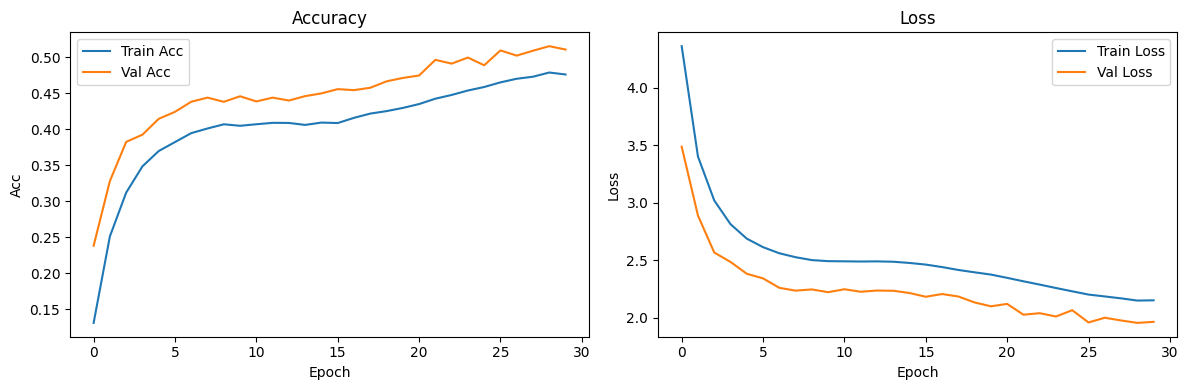

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()